In [1]:
from trading_agent.trading_simulator import TradingSimulator, TradingSimulatorConfig
from trading_agent.random_trading_agent import RandomTradingAgent
from trading_agent.explainable_option_trading_agent import ExplainableOptionTradingAgent
from trading_agent.base_trading_agent import BaseTradingAgent
from trading_agent.utils.order_hist_visualizer import plot_order_history
import pandas as pd
from collections import defaultdict
import json
from pprint import pprint
from tqdm import tqdm
import numpy as np

In [ ]:
TEST_RATIO = 0.2

REWARD_FACTOR = 0.99
LOSS_FACTOR = 1.01
INIT_BALANCE = 100

RANDOM_TESTING_TIMES = 3000
EXPLAINABLE_TESTING_TIMES = 300
BUY_ONLY_TESTING_TIMES = 1
SELL_ONLY_TESTING_TIMES = 1

CONSECUTIVE_DAYS = 5

# Create dataset

In [3]:
sentiment_df = pd.read_csv("../data/tesla_tweets_with_sentiment_all.csv")
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"]).dt.date

In [4]:
# Compute split date
dates = sentiment_df["Date"].unique()[::-1]
split_index = int(len(dates) * (1 - TEST_RATIO))
split_date = dates[split_index]
print(f"Split date: {split_date}")

Split date: 2022-07-19


In [5]:
# Load price data
price_df = pd.read_csv("../data/date_with_x_t.csv")
price_df = price_df.dropna()
price_df["Date"] = pd.to_datetime(price_df["Date"]).dt.date
price_df["is_train"] = price_df["Date"] < split_date

# Merge price and sentiment dataframes and mark train/test split
price_and_sentiment_df = pd.merge(price_df, sentiment_df, on="Date", how="inner")

In [6]:
price_and_sentiment_df.groupby("Date").agg(
    postive_count=("sentiment_label", lambda x: (x == "positive").sum()),
    negative_count=("sentiment_label", lambda x: (x == "negative").sum()),
    neutral_count=("sentiment_label", lambda x: (x == "neutral").sum()),
).mean(axis=0)

postive_count     46.865079
negative_count    21.063492
neutral_count     51.230159
dtype: float64

In [ ]:
def recalibrate_sentiment(price_and_sentiment_df, max_date):
    """
    Due to very few negative tweets, we need to recalibrate the sentiment scores
    Which this function will label low confidence 'positive' sentiments as 'neutral'
    and the threshold for 'positive' sentiment is set by use the minimum score that make mean of
    negative sentiment and positive sentiment are most close
    """
    # Compute the sum of positive and negative sentiment counts each day
    price_and_sentiment_df = price_and_sentiment_df.groupby("Date").agg(
        postive_count=("sentiment_label", lambda x: (x == "positive").sum()),
        negative_count=("sentiment_label", lambda x: (x == "negative").sum()),
        neutral_count=("sentiment_label", lambda x: (x == "neutral").sum()),
        x_t=("x_t", "first"),
        is_train=("is_train", "first"),
    )
    # get the mean of x_t over 5 days
    price_and_sentiment_df["x_t_mean"] = price_and_sentiment_df["x_t"].rolling(CONSECUTIVE_DAYS).mean()
    price_and_sentiment_df["pos_count_first"] = price_and_sentiment_df["postive_count"].shift(CONSECUTIVE_DAYS)
    price_and_sentiment_df["neg_count_first"] = price_and_sentiment_df["negative_count"].shift(CONSECUTIVE_DAYS)
    price_and_sentiment_df["neutral_count_first"] = price_and_sentiment_df["neutral_count"].shift(CONSECUTIVE_DAYS)

    # Get the positive count that makes the price up for CONSECUTIVE_DAYS
    mean_target_pos = price_and_sentiment_df[price_and_sentiment_df["x_t_mean"] == 1]["pos_count_first"].mean()
    mean_target_neg = price_and_sentiment_df[price_and_sentiment_df["x_t_mean"] == 0]["neg_count_first"].mean()
    weight_for_neg = 1 / (mean_target_neg / mean_target_pos)
    print(f"Weight for negative sentiment: {weight_for_neg}")
    sentiment_weights = {"positive": 1, "negative": float(weight_for_neg), "neutral": 1}

    price_and_sentiment_df["positive_weight"] = price_and_sentiment_df["postive_count"] * sentiment_weights["positive"]
    price_and_sentiment_df["negative_weight"] = price_and_sentiment_df["negative_count"] * sentiment_weights["negative"]
    price_and_sentiment_df["neutral_weight"] = price_and_sentiment_df["neutral_count"] * sentiment_weights["neutral"]

    price_and_sentiment_df["sentiment_major"] = price_and_sentiment_df[
        ["positive_weight", "negative_weight", "neutral_weight"]
    ].idxmax(axis=1)
    price_and_sentiment_df["sentiment_major"] = price_and_sentiment_df["sentiment_major"].apply(
        lambda x: x.split("_")[0]
    )

    return price_and_sentiment_df, sentiment_weights


price_and_sentiment_df, sentiment_weights = recalibrate_sentiment(price_and_sentiment_df, max_date=split_date)

Weight for negative sentiment: 2.726744186046512


In [8]:
print(sentiment_weights)

{'positive': 1, 'negative': 2.726744186046512, 'neutral': 1}


In [9]:
p_et = dict()

sentiment_count = price_and_sentiment_df.groupby("sentiment_major").agg(
    count=("sentiment_major", "size"),
)
total_count = sentiment_count["count"].sum()

for sentiment in sentiment_count.index:
    p_et[sentiment] = float(sentiment_count.loc[sentiment].iloc[0] / total_count)

with open("./p_et.json", "w") as f:
    json.dump(p_et, f, indent=4)

In [10]:
p_et

{'negative': 0.5357142857142857,
 'neutral': 0.23015873015873015,
 'positive': 0.23412698412698413}

In [11]:
p_xt = dict()

price_up_amount = price_and_sentiment_df[price_and_sentiment_df["is_train"]]["x_t"].sum()
price_down_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]]) - price_up_amount
total_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]])

p_xt["up"] = float(price_up_amount / total_amount)
p_xt["down"] = float(price_down_amount / total_amount)

with open("./p_xt.json", "w") as f:
    json.dump(p_xt, f, indent=4)
pprint(p_xt)

{'down': 0.48, 'up': 0.52}


In [12]:
p_et_given_xt = defaultdict(dict)

for sentiment in p_et.keys():
    for price_state in p_xt.keys():
        # Find prob of sentiment given price state
        current_xt_and_et = price_and_sentiment_df[
            (price_and_sentiment_df["is_train"])
            & (price_and_sentiment_df["sentiment_major"] == sentiment)
            & (price_and_sentiment_df["x_t"] == (1 if price_state == "up" else 0))
        ]
        total_amount = len(price_and_sentiment_df[price_and_sentiment_df["is_train"]])

        p_et_and_xt = len(current_xt_and_et) / total_amount
        p_et_given_xt[sentiment][price_state] = float(p_et_and_xt / p_xt[price_state])
p_et_given_xt = dict(p_et_given_xt)

with open("./p_et_given_xt.json", "w") as f:
    json.dump(p_et_given_xt, f, indent=4)
pprint(p_et_given_xt)

{'negative': {'down': 0.6458333333333334, 'up': 0.45192307692307687},
 'neutral': {'down': 0.20833333333333334, 'up': 0.25961538461538464},
 'positive': {'down': 0.14583333333333334, 'up': 0.28846153846153844}}


In [13]:
p_xt_given_xprevt = defaultdict(dict)

# Find prob of price state given previous price state
temp_df = price_and_sentiment_df.copy()
temp_df["x_t-1"] = temp_df["x_t"].shift(1).astype("Int64")
temp_df = temp_df[1:]


for price_state in p_xt.keys():
    for prev_price_state in p_xt.keys():
        # Find prob of price state given previous price state
        current_xt_and_xprevt = temp_df[
            (temp_df["is_train"])
            & (temp_df["x_t"] == (1 if price_state == "up" else 0))
            & (temp_df["x_t-1"] == (1 if prev_price_state == "up" else 0))
        ]
        total_amount = len(temp_df[temp_df["is_train"]])

        p_xt_and_xprevt = len(current_xt_and_xprevt) / total_amount
        p_xt_given_xprevt[price_state][prev_price_state] = float(p_xt_and_xprevt / p_xt[prev_price_state])

p_xt_given_xprevt = dict(p_xt_given_xprevt)
with open("./p_xt_given_xprevt.json", "w") as f:
    json.dump(p_xt_given_xprevt, f, indent=4)

pprint(p_xt_given_xprevt)

{'down': {'down': 0.5025125628140703, 'up': 0.45419404715887124},
 'up': {'down': 0.49204355108877723, 'up': 0.5508310784692695}}


In [14]:
# Create a new dataframe with the merged data
price_tsla_1d = pd.read_csv("../data/price_1d_tsla.csv")
price_tsla_1d["Date"] = pd.to_datetime(price_tsla_1d["Date"]).dt.date

df = pd.merge(price_tsla_1d, price_and_sentiment_df, on="Date", how="right")

In [15]:
df.to_csv("./tesing.csv")

# Run testing

In [16]:
split_date = "2022-07-19"

In [17]:
def test_multiple_times(
    trading_agent: BaseTradingAgent, trading_sim: TradingSimulator, num_times: int = 10, tqdm_disable: bool = False
):
    """
    Test the trading agent multiple times and return the average profit
    """
    best_result, best_state_history = None, None
    worse_result, worse_state_history = None, None
    run_history = []

    # Run the simulation multiple times
    for _ in tqdm(range(num_times), disable=tqdm_disable):
        trading_agent.reset_state()
        result = trading_sim.run_simulation(trading_agent)
        # Store the balance history
        run_history.append(result)

        if best_result is None or result.balance > best_result.balance:
            best_result = result
            try:
                best_state_history = trading_agent.state_history
            except AttributeError:
                best_state_history = None
        if worse_result is None or result.balance < worse_result.balance:
            worse_result = result
            try:
                worse_state_history = trading_agent.state_history
            except AttributeError:
                worse_state_history = None

    balance_history = np.array([result.balance for result in run_history])

    return {
        "best_result": best_result,
        "worse_result": worse_result,
        "best_profit": round((best_result.balance - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "worse_profit": round((worse_result.balance - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "average_profit": round((balance_history.sum() / len(balance_history) - INIT_BALANCE) / INIT_BALANCE * 100, 2),
        "std_dev": round((balance_history.std()), 2),
        "best_state_history": best_state_history,
        "worse_state_history": worse_state_history,
    }

In [18]:
trading_sim_config = TradingSimulatorConfig(
    price_dataframe_path="./tesing.csv",
    buy_at="Open",
    sell_at="Close",
    trade_type="option",
    reward_factor=REWARD_FACTOR,
    loss_factor=LOSS_FACTOR,
    initial_balance=INIT_BALANCE,
)
trading_sim = TradingSimulator(trading_sim_config)

## Random trading agent

In [19]:
best_result, worse_result, best_profit, worse_profit, average_profit, std_dev, best_state_history, worse_state_history = test_multiple_times(
    RandomTradingAgent(), trading_sim, num_times=RANDOM_TESTING_TIMES
).values()

print("Best result profit    :", best_profit, "%")
print("Worse result profit   :", worse_profit, "%")
print()
print("Average profit        :", average_profit, "%")
print("Standard deviation    :", std_dev, "%")

100%|██████████| 3000/3000 [00:24<00:00, 123.94it/s]

Best result profit    : 46.49 %
Worse result profit   : -61.51 %

Average profit        : -2.1 %
Standard deviation    : 15.93 %


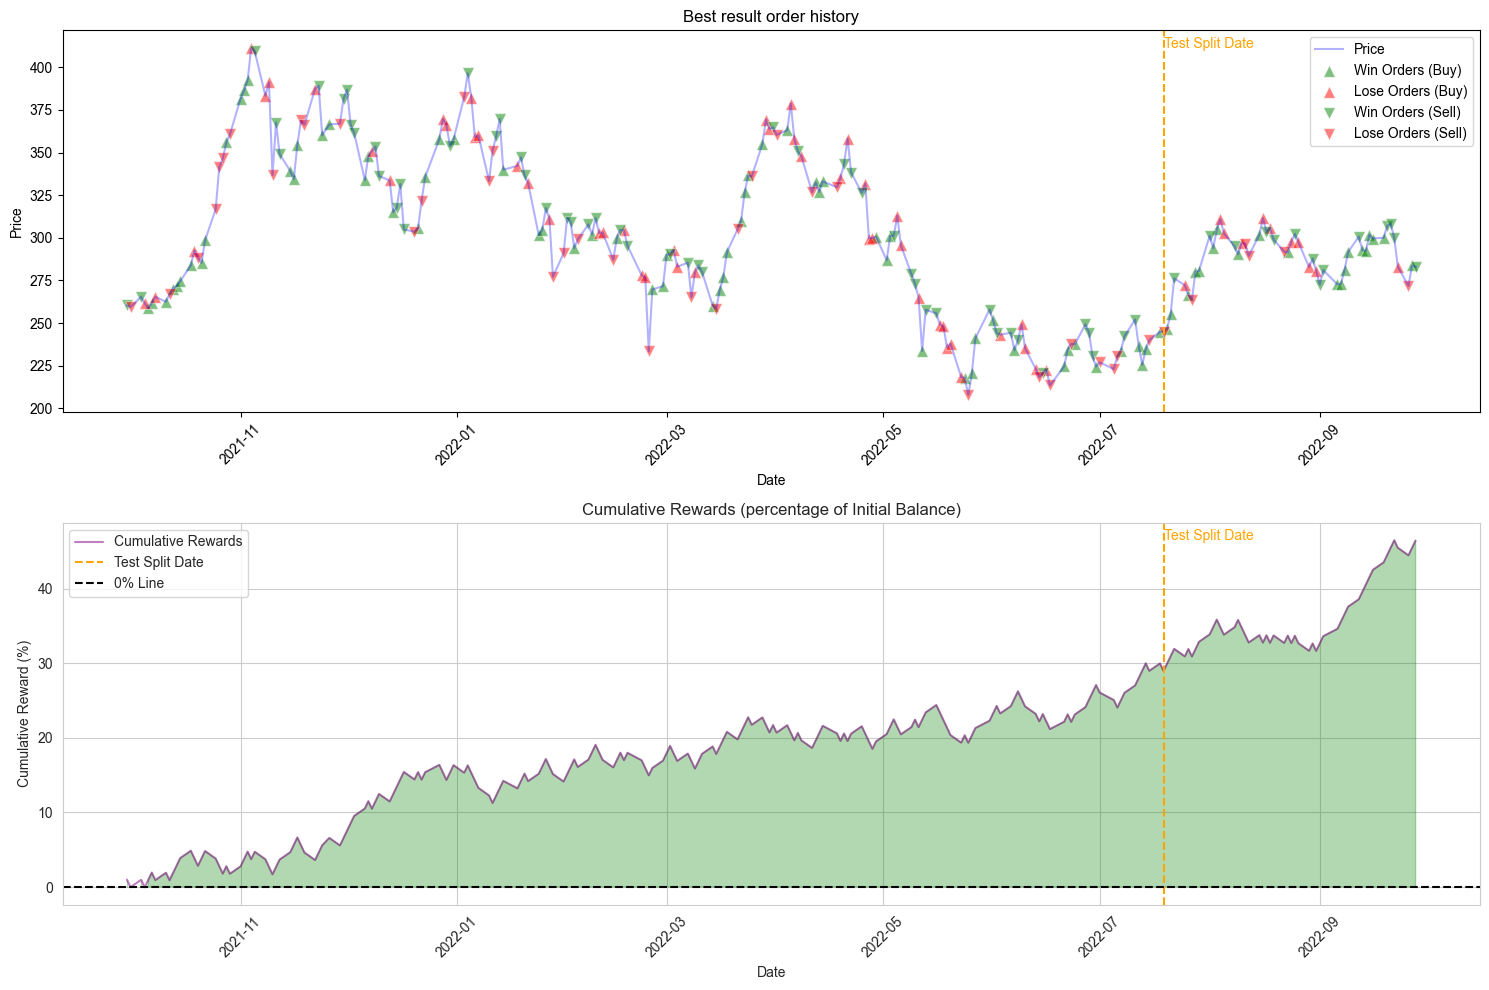

In [20]:
plot_order_history(
    best_result.order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date
)

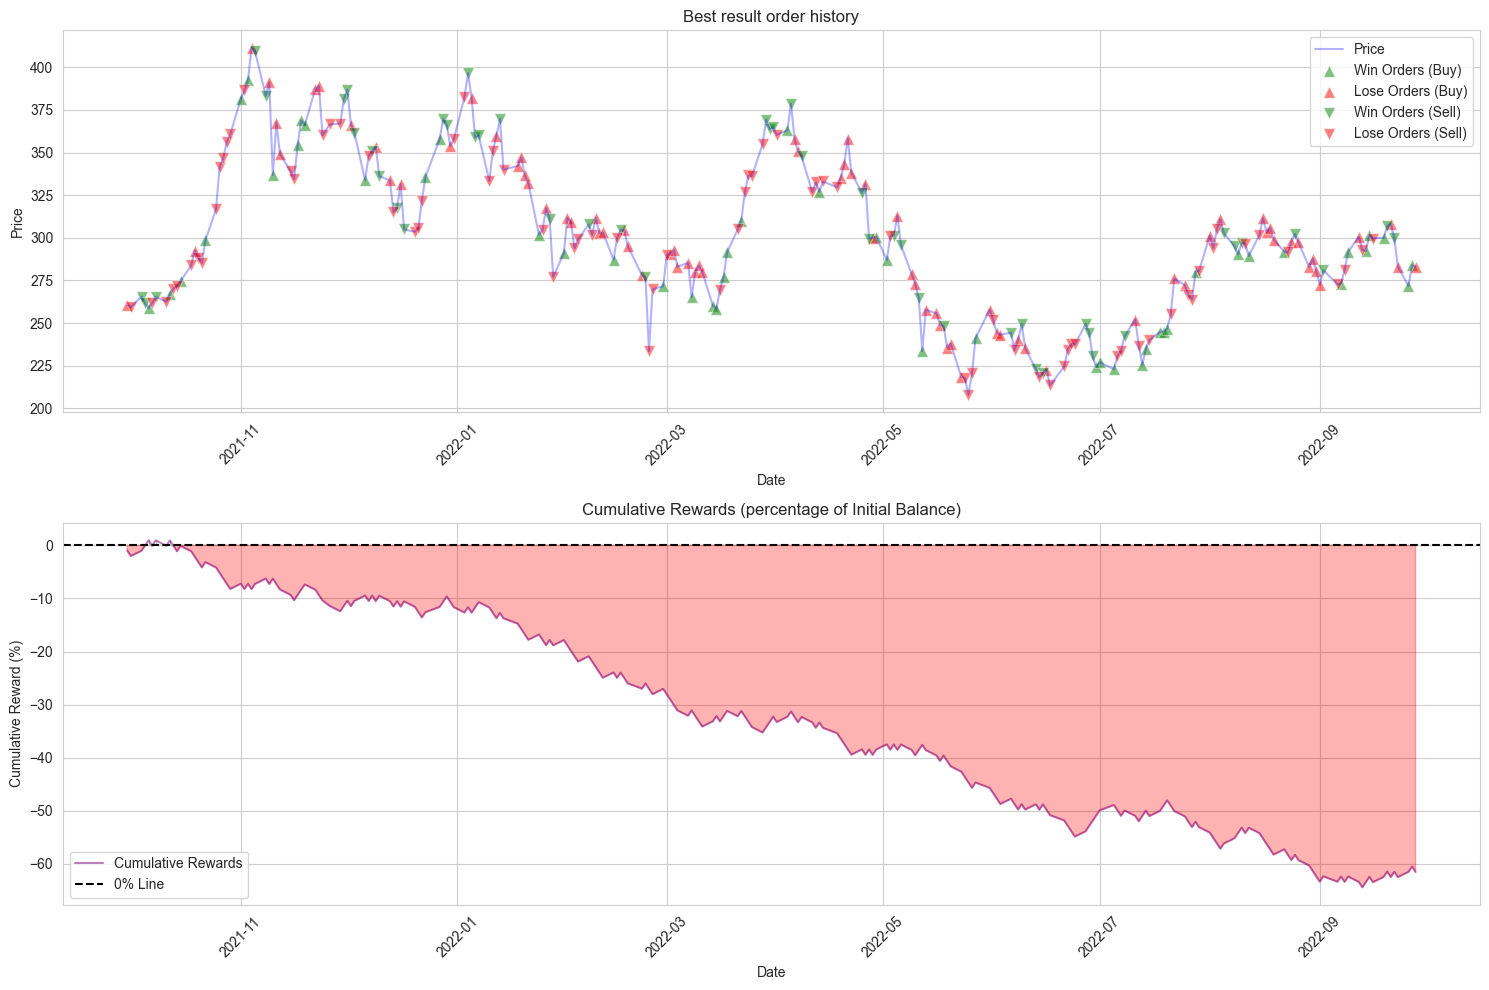

In [21]:
plot_order_history(
    orders=worse_result.order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
)

## Explainable trading agent

In [22]:
from trading_agent.explainable_option_trading_agent import ExplainableOptionTradingAgent

In [23]:
explainable_trading_agent = ExplainableOptionTradingAgent(
    p_et_path="./p_et.json",
    p_xt_path="./p_xt.json",
    p_et_given_xt_path="./p_et_given_xt.json",
    p_xt_given_xprevt_path="./p_xt_given_xprevt.json",
    inference_method="forward_predict",
    picking_action_method="select_max_prob",
)

In [24]:
best_result, worse_result, best_profit, worse_profit, average_profit, std_dev, best_state_history, worse_state_history = test_multiple_times(
    explainable_trading_agent, trading_sim, num_times=EXPLAINABLE_TESTING_TIMES
).values()

print("Best result profit    :", best_profit, "%")
print("Worse result profit   :", worse_profit, "%")
print()
print("Average profit        :", average_profit, "%")
print("Standard deviation    :", std_dev, "%")

100%|██████████| 300/300 [00:02<00:00, 107.60it/s]

Best result profit    : 42.49 %
Worse result profit   : 42.49 %

Average profit        : 42.49 %
Standard deviation    : 0.0 %


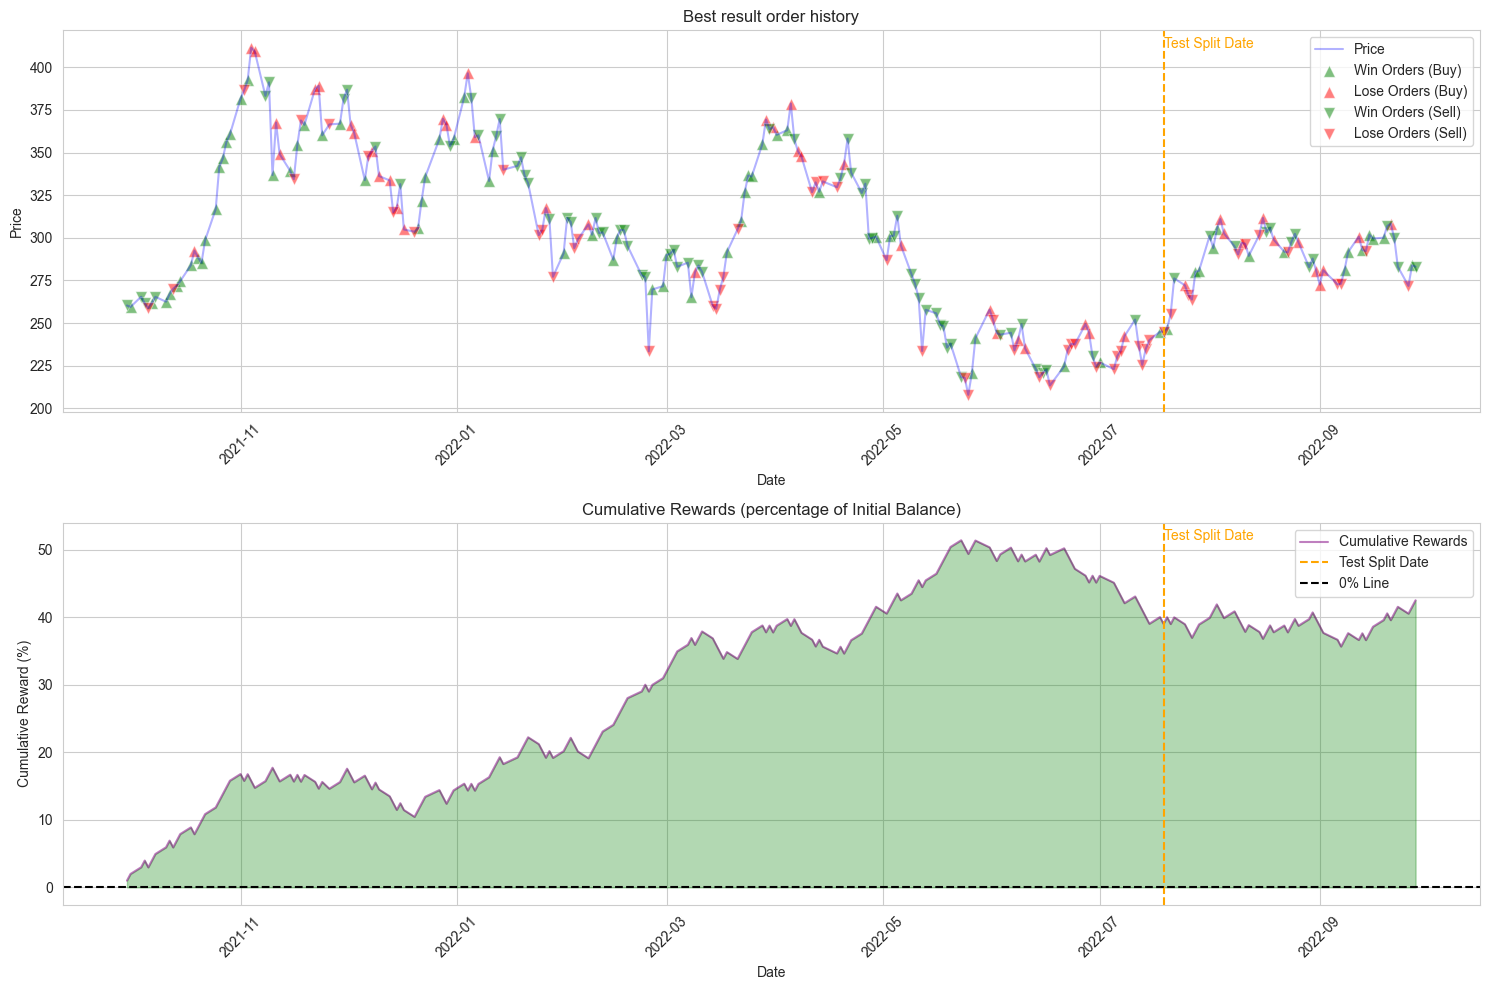

In [25]:
plot_order_history(
    best_result.order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date,
)

In [26]:
best_state_history
# Convert date and predicted_xt of each State to a dataframe
state_history_df = pd.DataFrame(
    [
        {
            # "Date": state.date,
            "Date": pd.to_datetime(state.date).date(),
            "predicted_xt": state.predicted_xt,
        }
        for state in best_state_history
    ]
)
temp_df = pd.merge(state_history_df, price_and_sentiment_df, on="Date", how="inner")[["Date", "predicted_xt", "x_t"]]
temp_df["predicted_xt"] = temp_df["predicted_xt"].apply(lambda x: 1 if x == "up" else 0)

              precision    recall  f1-score   support

        Down       0.56      0.61      0.58       122
          Up       0.60      0.54      0.57       130

    accuracy                           0.58       252
   macro avg       0.58      0.58      0.58       252
weighted avg       0.58      0.58      0.57       252



Text(0.5, 1.0, 'Confusion Matrix')

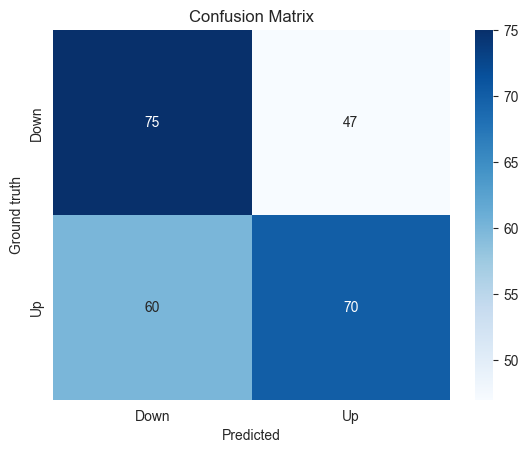

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

print(classification_report(temp_df["x_t"], temp_df["predicted_xt"], labels=[0, 1], target_names=["Down", "Up"]))

report = confusion_matrix(temp_df["x_t"], temp_df["predicted_xt"])
sns.heatmap(
    report,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Down", "Up"],
    yticklabels=["Down", "Up"],
)
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
plt.title("Confusion Matrix")

## Buy only agent

In [33]:
class OnlyOneChoiceTradingAgent(BaseTradingAgent):
    def __init__(self, result: str) -> None:
        self.result = result

    def get_action(self, **kwargs) -> str:
        # Randomly choose an action: buy, sell, or hold
        return self.result

In [ ]:
best_result, worse_result, best_profit, worse_profit, average_profit, std_dev, best_state_history, worse_state_history = test_multiple_times(
    OnlyOneChoiceTradingAgent("buy"), trading_sim, num_times=BUY_ONLY_TESTING_TIMES
).values()

print("Best result profit    :", best_profit, "%")
print("Worse result profit   :", worse_profit, "%")
print()
print("Average profit        :", average_profit, "%")
print("Standard deviation    :", std_dev, "%")

100%|██████████| 1/1 [00:00<00:00, 64.54it/s]

Best result profit    : -1.51 %
Worse result profit   : -1.51 %

Average profit        : -1.51 %
Standard deviation    : 0.0 %


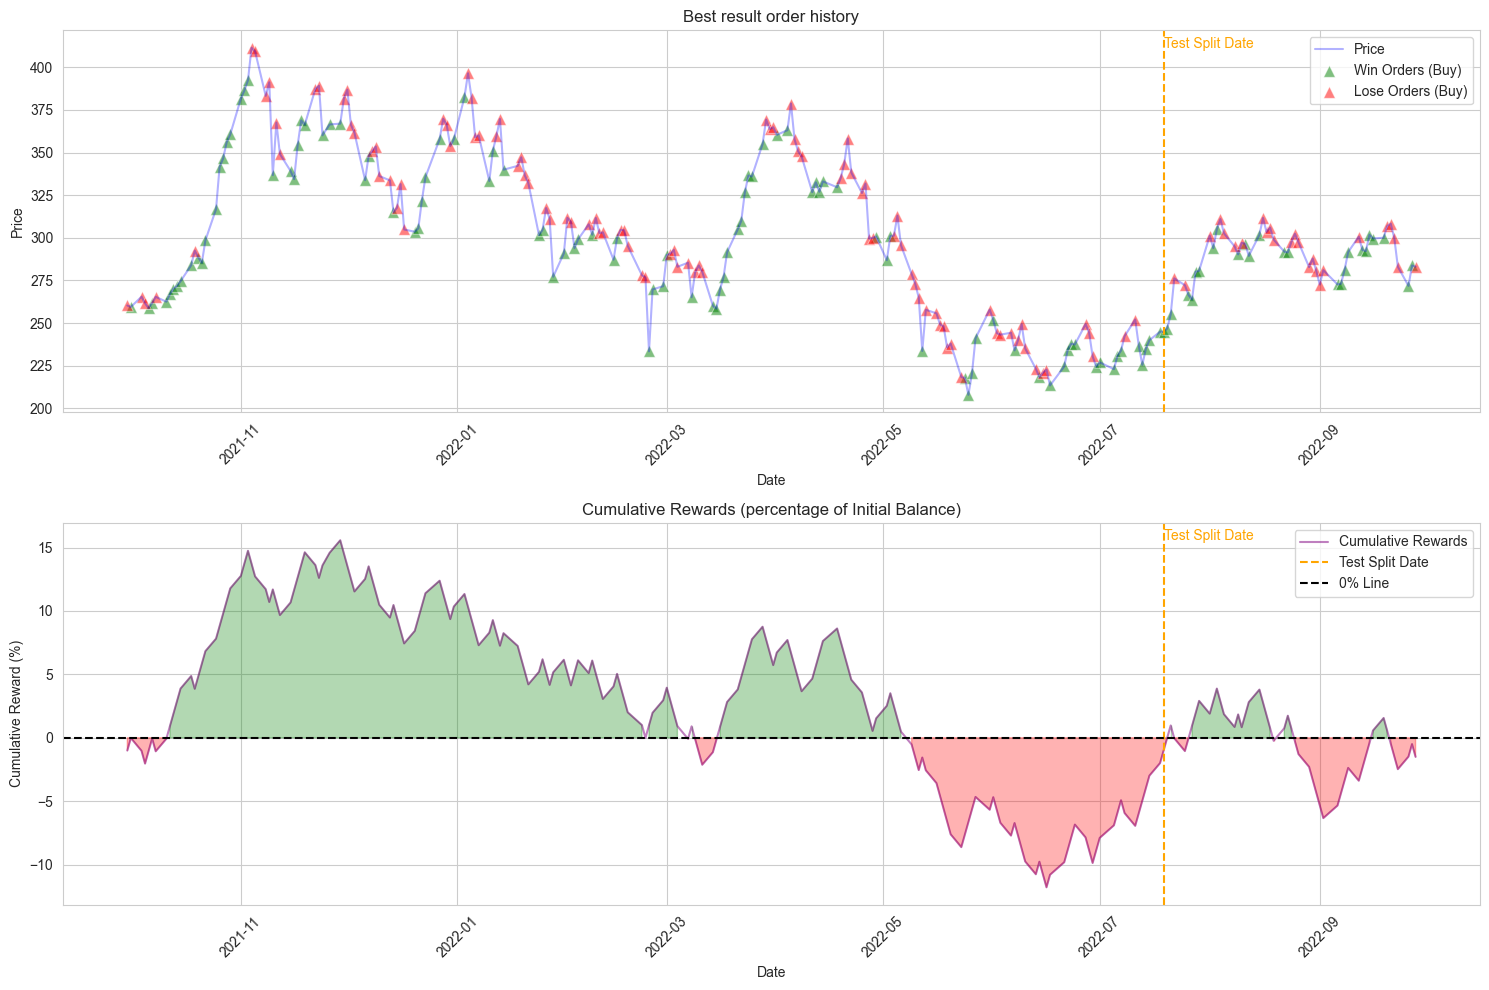

In [30]:
plot_order_history(
    best_result.order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date
)

## Sell only agent

In [34]:
best_result, worse_result, best_profit, worse_profit, average_profit, std_dev, best_state_history, worse_state_history = test_multiple_times(
    OnlyOneChoiceTradingAgent("sell"), trading_sim, num_times=BUY_ONLY_TESTING_TIMES
).values()

print("Best result profit    :", best_profit, "%")
print("Worse result profit   :", worse_profit, "%")
print()
print("Average profit        :", average_profit, "%")
print("Standard deviation    :", std_dev, "%")

100%|██████████| 1/1 [00:00<00:00, 43.06it/s]

Best result profit    : -3.51 %
Worse result profit   : -3.51 %

Average profit        : -3.51 %
Standard deviation    : 0.0 %


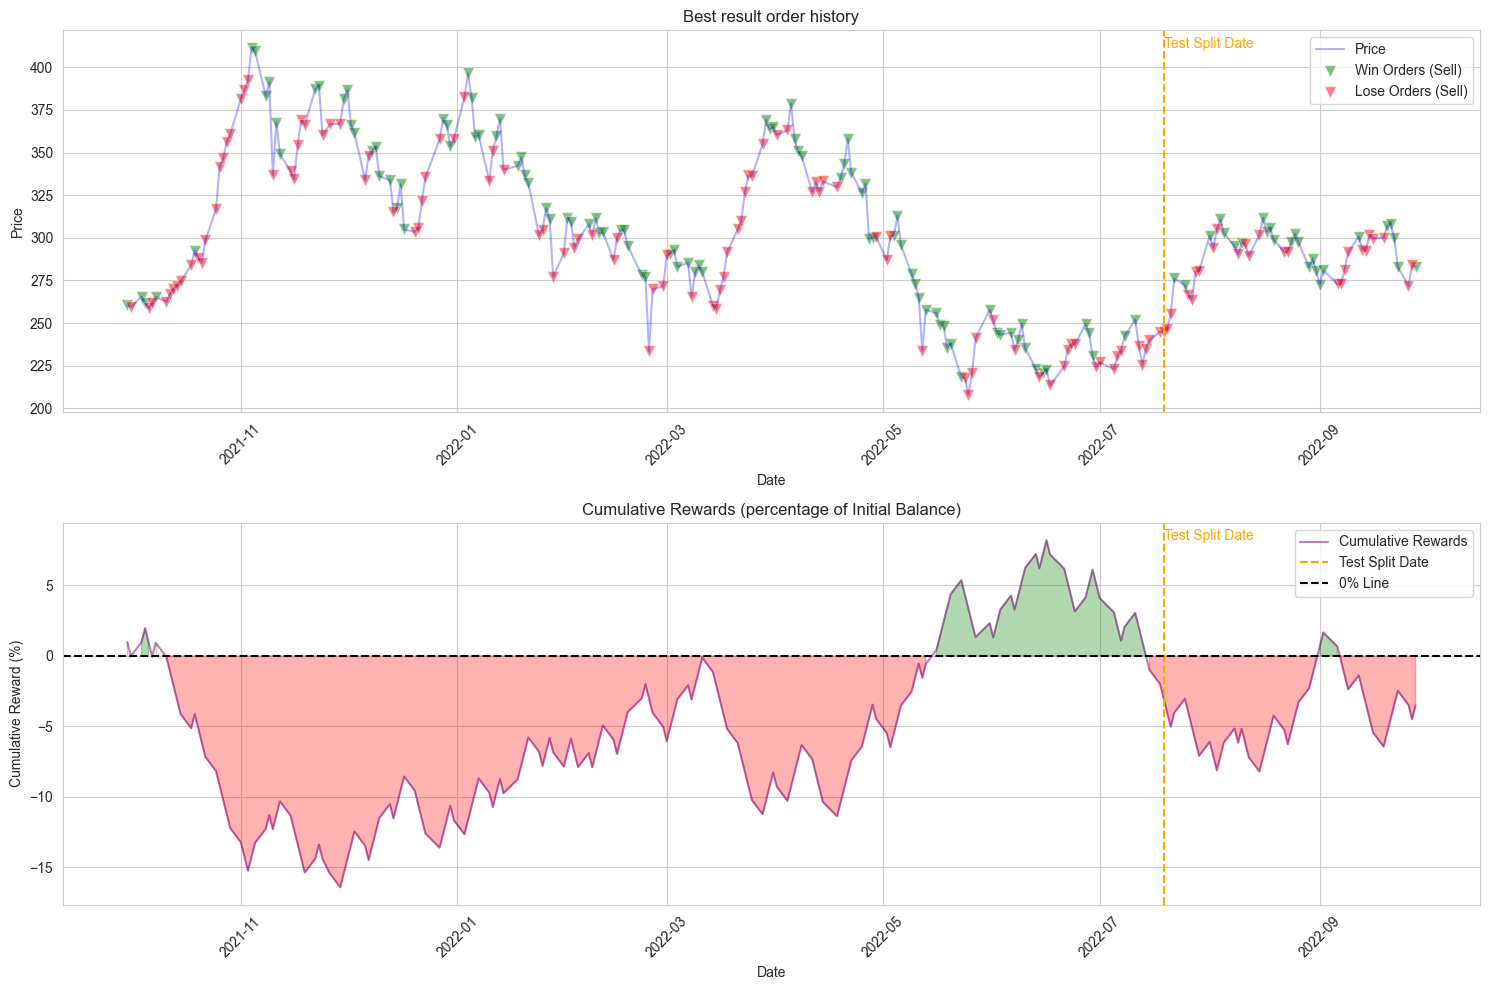

In [35]:
plot_order_history(
    best_result.order_history,
    initial_balance=INIT_BALANCE,
    title="Best result order history",
    test_split_date=split_date
)